<h2 style="color:darkcyan;">1. Creación, entrenamiento y validación del modelo: </h2>

Para este apartado, empezaremos creando varios modelos, para ello hemos escogido las siguientes opciones:

* Modelo red neuronal con GridSearch para busqueda de mejor conbinación

* Modelo LSTM para la correcta predicción del precio en los próximos 10 dias

* Modelo de regresión lineal básico 

Para todos ellos mostraremos sus metricas de validación,etc.

Estos modelos han sido creados y entrenados usando GPU con las siguientes versiones:

* Python 3.10
* Tensorflow 2.13.0
* Cuda toolkit 11.8
* CuDNN 8.9.7


<h2 style="color:darkcyan;">2. Red neuronal con GridSearch </h2>

Vamos a crear un modelo de red neuronal probando distintos hiperparametros, para ello usaremos una busqueda automatica usando la funcion tuner.search

* Primero realizamos los import necesarios para los modelos

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import keras_tuner as kt

import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from datetime import timedelta

from sklearn.linear_model import LinearRegression

2025-05-26 01:23:26.165874: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-26 01:23:26.194762: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-05-26 01:23:26.638775: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Ahora cargaremos los datos del `.csv` generado en el hito anterior, generando los datos de entrenamiento y validación

In [2]:
df = pd.read_csv("btc_datos_escalados.csv")
X = df.drop(columns=['precio_btc', 'timestamp']).values
y = df['precio_btc'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

A continuación creamos el modelo base a usar con las siguientes características:

* Número de neuronas en la primera capa (32, 64, 128)
* Activaciones ('relu', 'tanh')
* Optimizers ('adam', 'rmsprop')

In [3]:
def build_model(hp):
    model = keras.Sequential()
    # Neuronas
    neurons = hp.Choice('neurons', values=[32, 64, 128])
    # Activación
    activation = hp.Choice('activation', values=['relu', 'tanh'])
    # Optimizers
    optimizer_choice = hp.Choice('optimizer', values=['adam', 'rmsprop'])
    
    model.add(layers.Dense(neurons, activation=activation, input_shape=(X_train.shape[1],)))
    model.add(layers.Dense(neurons, activation=activation))
    model.add(layers.Dense(1))
    
    optimizer = None
    if optimizer_choice == 'adam':
        optimizer = keras.optimizers.Adam()
    else:
        optimizer = keras.optimizers.RMSprop()
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    return model

Ahora es momento de crear el tuner para la busqueda del mejor modelo, hemos usado un tuner basico con la funcion GridSearch

In [4]:
tuner = kt.GridSearch(
    build_model,
    objective='val_loss',
    max_trials=12,  # 2 (optimizers) * 2 (activations) * 3 (neurons) = 12 combinaciones
    executions_per_trial=1,
    directory='my_dir',
    project_name='btc_price_tuning'
)

INFO:tensorflow:Reloading Tuner from my_dir/btc_price_tuning/tuner0.json


Por último llamamos a la busqueda del tuner para encontrar los mejores resultados y guardamos el mejor modelo

In [5]:
tuner.search(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, verbose=1)

best_model = tuner.get_best_models(num_models=1)[0]

INFO:tensorflow:Oracle triggered exit


2025-05-26 01:23:36.877152: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-26 01:23:36.942110: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2025-05-26 01:23:36.944075: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Por último, evaluamos el modelo con los datos de test

In [6]:
y_pred = best_model.predict(X_test).flatten()

51/51 [==============================] - 0s 571us/step


2025-05-26 01:23:39.247049: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:606] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


<h3 style="color:darkcyan;">2.1. Resultados validación</h3>

Y para acabar mostramos los resultados de las metricas obtenidas

In [7]:
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("Mejores hiperparámetros encontrados:")
print(tuner.get_best_hyperparameters(1)[0].values)

print("\nMétricas del mejor modelo:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

Mejores hiperparámetros encontrados:
{'neurons': 128, 'activation': 'relu', 'optimizer': 'rmsprop'}

Métricas del mejor modelo:
MAE: 1580.05
RMSE: 2117.38
R²: 0.9883


* Despues de varios entrenamientos y comparaciones usadas por `GridSearch`, nos devuelve el modelo con mejores hiperparámetros

### Resultados

* Como podemos observar la mejor combinación obtenida `{'neurons': 128, 'activation': 'relu', 'optimizer': 'rmsprop'}` 

* Tambien observamos unas metricas bastante decentes para la red neuronal, con un R cuadrado de 0,988 y un margen de error en el precio de 2117.38€

<h2 style="color:darkcyan;">3. Modelo LSTM </h2>

Vamos a crear un modelo LSTM (Long Short-Term Memory), ideal para series temporales como la que vamos a hacer para predecir los proximos 10 dias. Este modelo podrá aprender patrones en secuencia y predecir de forma más realista.

* Para evitar problemas, volvemos a cargar los datos del `.csv` escalado del hito anterior

In [8]:
df = pd.read_csv("btc_datos_escalados.csv")
df['timestamp'] = pd.to_datetime(df['timestamp'])

Escalamos los precios con MinMaxScaler para mejor precisión

In [9]:
prices = df['precio_btc'].values.reshape(-1, 1)
scaler = MinMaxScaler()
scaled_prices = scaler.fit_transform(prices)

Ahora creamos las secuencias de los precios en un bucle

In [10]:
window_size = 30
X, y = [], []

for i in range(window_size, len(scaled_prices)):
    X.append(scaled_prices[i - window_size:i, 0])
    y.append(scaled_prices[i, 0])

X, y = np.array(X), np.array(y)
X = X.reshape((X.shape[0], X.shape[1], 1))

Y dividimos los datos de nuevo en entrenamiento y prueba

In [11]:
split = int(len(X) * 0.8)
X_train, y_train = X[:split], y[:split]
X_test, y_test = X[split:], y[split:]

Es hora de crear el modelo LSTM, para ello usamos:

* Una capa LSTM con 64 neuronas
* Una capa densa con 32 neuronas
* Una capa final de 1 neurona

In [12]:
model = Sequential([
    LSTM(64, activation='tanh', return_sequences=False, input_shape=(X.shape[1], 1)),
    Dense(32, activation='relu'),
    Dense(1)
])

Compilamos y entrenamos el modelo

In [13]:
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Epoch 1/50


2025-05-26 01:24:05.633311: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8907
2025-05-26 01:24:05.654232: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x731c1d81fdb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2025-05-26 01:24:05.654250: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4060, Compute Capability 8.9
2025-05-26 01:24:05.657632: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:255] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2025-05-26 01:24:05.748872: I ./tensorflow/compiler/jit/device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


181/181 [==============================] - 2s 3ms/step - loss: 0.0050 - val_loss: 2.9243e-04
Epoch 2/50
181/181 [==============================] - 0s 2ms/step - loss: 2.5070e-04 - val_loss: 2.5533e-04
Epoch 3/50
181/181 [==============================] - 0s 2ms/step - loss: 2.0784e-04 - val_loss: 3.3524e-04
Epoch 4/50
181/181 [==============================] - 0s 2ms/step - loss: 1.5079e-04 - val_loss: 3.3803e-04
Epoch 5/50
181/181 [==============================] - 0s 2ms/step - loss: 1.2159e-04 - val_loss: 1.3545e-04
Epoch 6/50
181/181 [==============================] - 0s 2ms/step - loss: 1.0391e-04 - val_loss: 1.4794e-04
Epoch 7/50
181/181 [==============================] - 0s 2ms/step - loss: 9.2349e-05 - val_loss: 1.2817e-04
Epoch 8/50
181/181 [==============================] - 0s 2ms/step - loss: 8.4854e-05 - val_loss: 2.2596e-04
Epoch 9/50
181/181 [==============================] - 0s 2ms/step - loss: 7.0838e-05 - val_loss: 1.5850e-04
Epoch 10/50
181/181 [======================

<h3 style="color:darkcyan;">3.1. Resultados validación</h3>

Ahora mostraremos los resultados de las metricas de validación de este modelo en el conjunto de prueba

In [14]:
y_pred_scaled = model.predict(X_test).flatten()
y_test_real = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()
y_pred_real = scaler.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Calculo de metricas
mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2 = r2_score(y_test_real, y_pred_real)

# Mostrar las metricas
print("\n--- Métricas en el conjunto de prueba ---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")

51/51 [==============================] - 0s 777us/step

--- Métricas en el conjunto de prueba ---
MAE: 675.85
RMSE: 749.29
R²: 0.9956


* Observamos unos resultados muy buenos respecto a la red neuronal previamente creada, con un margen de fallo de 749,29€ y un R cuadrado de 0.955.

<h3 style="color:darkcyan;">3.2. Prediccion de 10 dias</h3>

Para calcular los 10 proximos dias, obtendremos los ultimos dias que previamente definimos en la ventana y realizamos la predicción en un bucle de 10, que son los dias a predecir

In [15]:
last_sequence = scaled_prices[-window_size:].reshape(1, window_size, 1)
future_predictions = []

for _ in range(10):
    next_pred = model.predict(last_sequence)[0, 0]
    future_predictions.append(next_pred)
    new_seq = np.append(last_sequence[0, 1:, 0], next_pred)
    last_sequence = new_seq.reshape(1, window_size, 1)

future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1)).flatten()

1/1 [==============================] - 0s 14ms/step


Ahora visualizamos gráficamente la predicción para ver los resultados

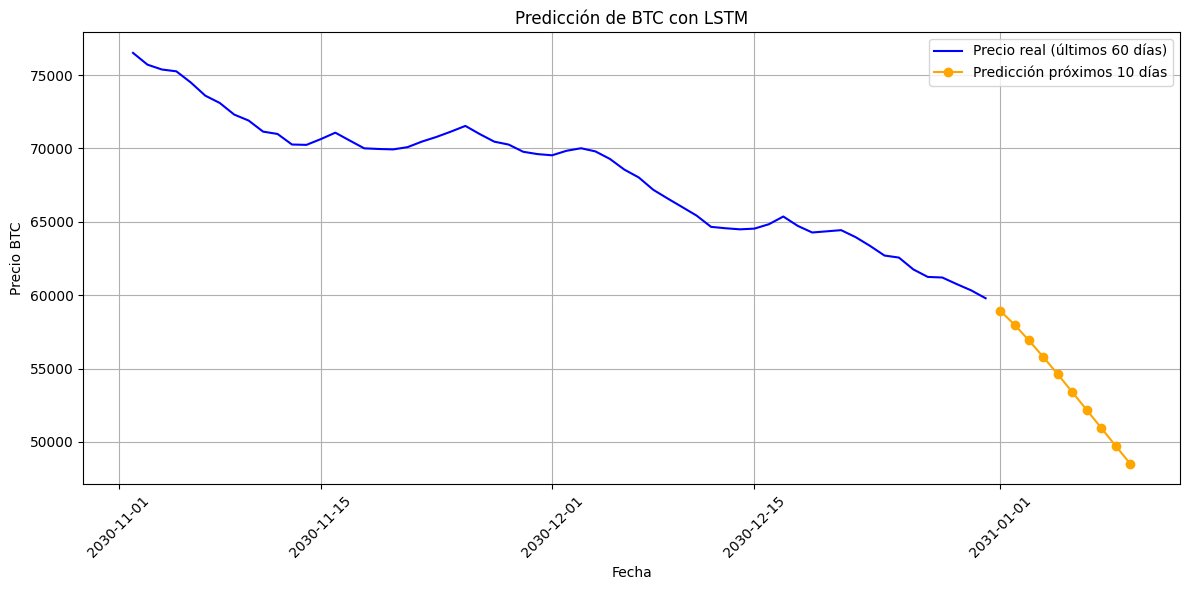

In [16]:
last_date = df['timestamp'].iloc[-1]
future_dates = [last_date + timedelta(days=i+1) for i in range(10)]

plt.figure(figsize=(12,6))
plt.plot(df['timestamp'][-60:], df['precio_btc'][-60:], label="Precio real (últimos 60 días)", color='blue')
plt.plot(future_dates, future_predictions, marker='o', label="Predicción próximos 10 días", color='orange')

plt.title("Predicción de BTC con LSTM")
plt.xlabel("Fecha")
plt.ylabel("Precio BTC")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Resultados

* Como observamos, apreciamos un descenso en el precio en los proximos 10 dias despues de la última fecha que poseemos, que seria el 31 de Diciembre de 2030

* Razonamos que se basa en la previa caida del precio en los ultimos dias

<h3 style="color:darkcyan;">3.3. Guardado del modelo</h3>

Procedemos a guardar el modelo para posterior uso en HugginFace, etc.

In [17]:
model.save("modelo1.h5")

/home/alberto/Escritorio/GPU/env/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


<h2 style="color:darkcyan;">4. Modelo Regresión Lineal</h2>

Vamos a crear un modelo de Regresión Lineal básico, para observar la predicción del precio respecto a los valores reales

* Para empezar volvemos a cargar los datos del `.csv` del hito anterior

In [18]:
df = pd.read_csv("btc_datos_escalados.csv")
df['timestamp'] = pd.to_datetime(df['timestamp']) # Pasamos a datetime

Dividimos los datos en entrenamiento y prueba

In [19]:
X = df.drop(columns=['precio_btc', 'timestamp']).values
y = df['precio_btc'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Creamos el modelo de regresión con `LineaRegression()` y lo entrenamos

In [20]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

<h3 style="color:darkcyan;">4.1. Resultados validación</h3>

Ahora predecimos y mostraremos los resultados de las metricas de validación de este modelo en el conjunto de prueba

In [21]:
# Predecimos
y_pred = model.predict(X_test)

# Generamos metricas
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print("\n--- Métricas de validación ---")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.4f}")


--- Métricas de validación ---
MAE: 1471.55
RMSE: 2261.97
R²: 0.9866


* Observamos unas metricas bastante buenas también, muy cercanas al modelo LSTM

<h3 style="color:darkcyan;">4.2. Prediccion del precio</h3>

Mostramos un gráfico del resultado de nuestra regresión

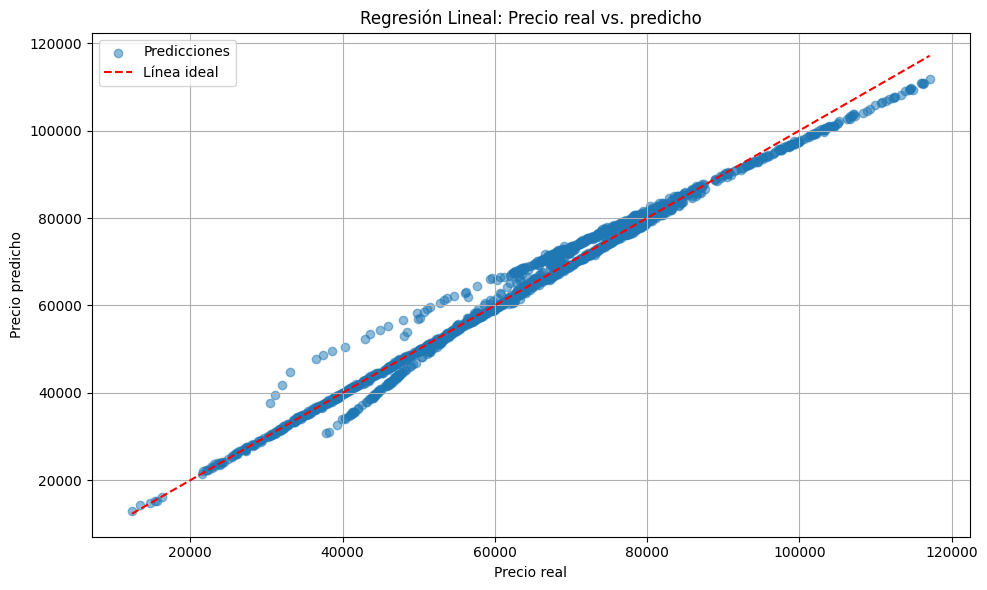

In [22]:
# --- 4. Gráfico: valores reales vs predichos ---
plt.figure(figsize=(10,6))
plt.scatter(y_test, y_pred, alpha=0.5, label='Predicciones')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--', label='Línea ideal')
plt.title("Regresión Lineal: Precio real vs. predicho")
plt.xlabel("Precio real")
plt.ylabel("Precio predicho")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Resultados

* Observamos una buena agrupación de predicciones respecto a los valores reales, aunque en valores altos tiende a caer un poco